# Colab D: PyTorch Lightning 3-Layer DNN for Non-Linear Regression

**Same Problem, Lightning Framework**

---

### Key Requirements
- `LightningModule` subclass with training/validation steps
- `LightningDataModule` for data handling
- Built-in `Trainer` for training loop
- Automatic logging, device management, and best practices

## Cell 1: Install & Import Dependencies

In [1]:
!pip install pytorch-lightning -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

torch.manual_seed(42)
np.random.seed(42)
print(f"PyTorch: {torch.__version__}")
print(f"PyTorch Lightning: {pl.__version__}")

PyTorch: 2.10.0+cpu
PyTorch Lightning: 2.6.1


## Cell 2: Generate Synthetic Data

In [2]:
num_samples = 2000
x1 = np.random.uniform(-2, 2, num_samples)
x2 = np.random.uniform(-2, 2, num_samples)
x3 = np.random.uniform(-2, 2, num_samples)
y_true = np.sin(x1) * x2**2 + np.cos(x3) * x1 + 0.5 * x3 * x2

X_np = np.column_stack([x1, x2, x3]).astype(np.float32)
Y_np = y_true.reshape(-1, 1).astype(np.float32)
X_mean, X_std = X_np.mean(0), X_np.std(0)
Y_mean, Y_std = Y_np.mean(), Y_np.std()
X_norm = (X_np - X_mean) / X_std
Y_norm = (Y_np - Y_mean) / Y_std

print(f"Data: {X_np.shape[0]} samples, {X_np.shape[1]} features")

Data: 2000 samples, 3 features


## Cell 3: 4D Data Visualization

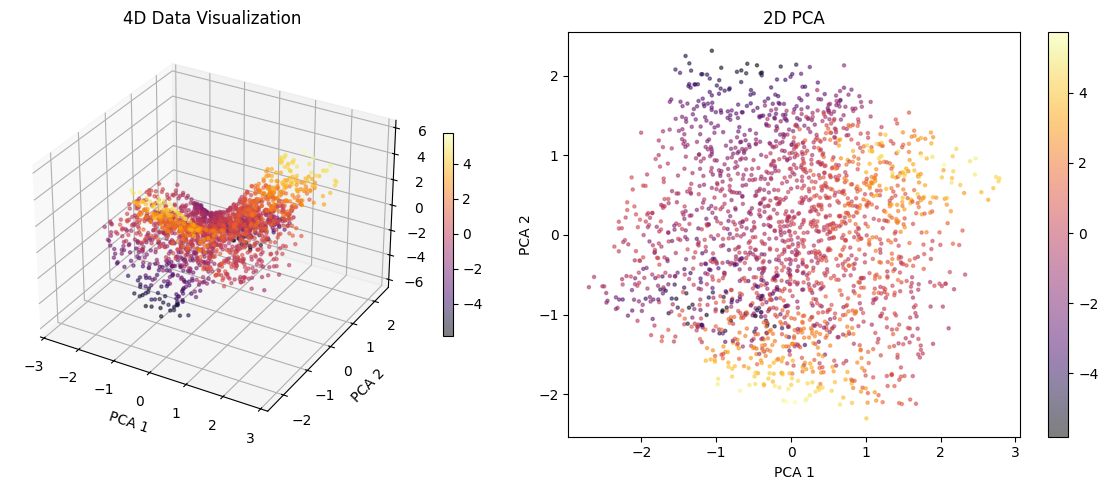

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], Y_np.flatten(), c=Y_np.flatten(), cmap='inferno', s=5, alpha=0.5)
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('y')
ax.set_title('4D Data Visualization')
plt.colorbar(sc, ax=ax, shrink=0.5)

ax2 = fig.add_subplot(122)
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_np.flatten(), cmap='inferno', s=5, alpha=0.5)
ax2.set_xlabel('PCA 1'); ax2.set_ylabel('PCA 2'); ax2.set_title('2D PCA')
plt.colorbar(sc2, ax=ax2)
plt.tight_layout(); plt.show()

## Cell 4: Define LightningDataModule

In [4]:
class RegressionDataModule(pl.LightningDataModule):
    """Lightning DataModule for the non-linear regression dataset."""

    def __init__(self, X, Y, batch_size=64, train_ratio=0.8):
        super().__init__()
        self.batch_size = batch_size
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.train_ratio = train_ratio

    def setup(self, stage=None):
        dataset = TensorDataset(self.X, self.Y)
        train_size = int(self.train_ratio * len(dataset))
        val_size = len(dataset) - train_size
        self.train_ds, self.val_ds = random_split(dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

dm = RegressionDataModule(X_norm, Y_norm)
print("LightningDataModule defined.")

LightningDataModule defined.


## Cell 5: Define LightningModule (3-Layer DNN)

In [5]:
class LitRegressionNet(pl.LightningModule):
    """PyTorch Lightning 3-Layer DNN for non-linear regression."""

    def __init__(self, input_dim=3, hidden_dims=[64, 32, 16], output_dim=1, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.ReLU(),
            nn.Linear(hidden_dims[2], output_dim)
        )

        self.criterion = nn.MSELoss()

        # For tracking losses
        self.training_losses = []
        self.validation_losses = []

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        avg_loss = self.trainer.callback_metrics.get('train_loss')
        if avg_loss is not None:
            self.training_losses.append(avg_loss.item())

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        avg_loss = self.trainer.callback_metrics.get('val_loss')
        if avg_loss is not None:
            self.validation_losses.append(avg_loss.item())

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

model = LitRegressionNet()
print(model)
print(f"\nTotal params: {sum(p.numel() for p in model.parameters())}")

LitRegressionNet(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

Total params: 2881


## Cell 6: Train with Lightning Trainer

In [6]:
trainer = Trainer(
    max_epochs=30,
    enable_progress_bar=True,
    log_every_n_steps=5,
    enable_checkpointing=False,
    logger=False  # Disable default logger for simplicity in Colab
)

trainer.fit(model, dm)
print("\nTraining complete!")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ network   │ Sequential │  2.9 K │ train │     0 │
│ 1 │ criterion │ MSELoss    │      0 │ train │     0 │
└───┴───────────┴────────────┴────────┴───────┴───────┘

Trainable params: 2.9 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.9 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 9                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.



Training complete!


## Cell 7: Plot Training History

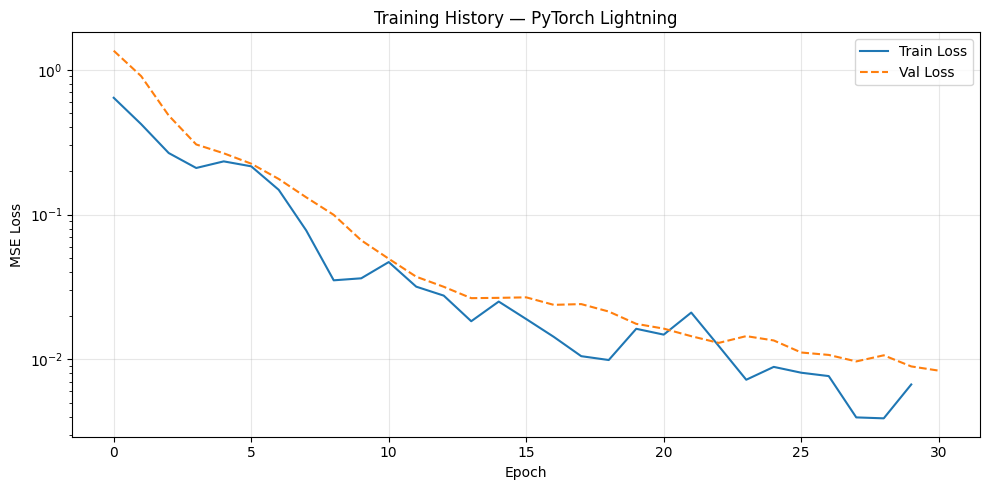

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
if model.training_losses:
    ax.plot(model.training_losses, label='Train Loss', linewidth=1.5)
if model.validation_losses:
    ax.plot(model.validation_losses, label='Val Loss', linewidth=1.5, linestyle='--')
ax.set_xlabel('Epoch'); ax.set_ylabel('MSE Loss')
ax.set_title('Training History — PyTorch Lightning')
ax.legend(); ax.grid(True, alpha=0.3); ax.set_yscale('log')
plt.tight_layout(); plt.show()

## Cell 8: Final Predictions & Results

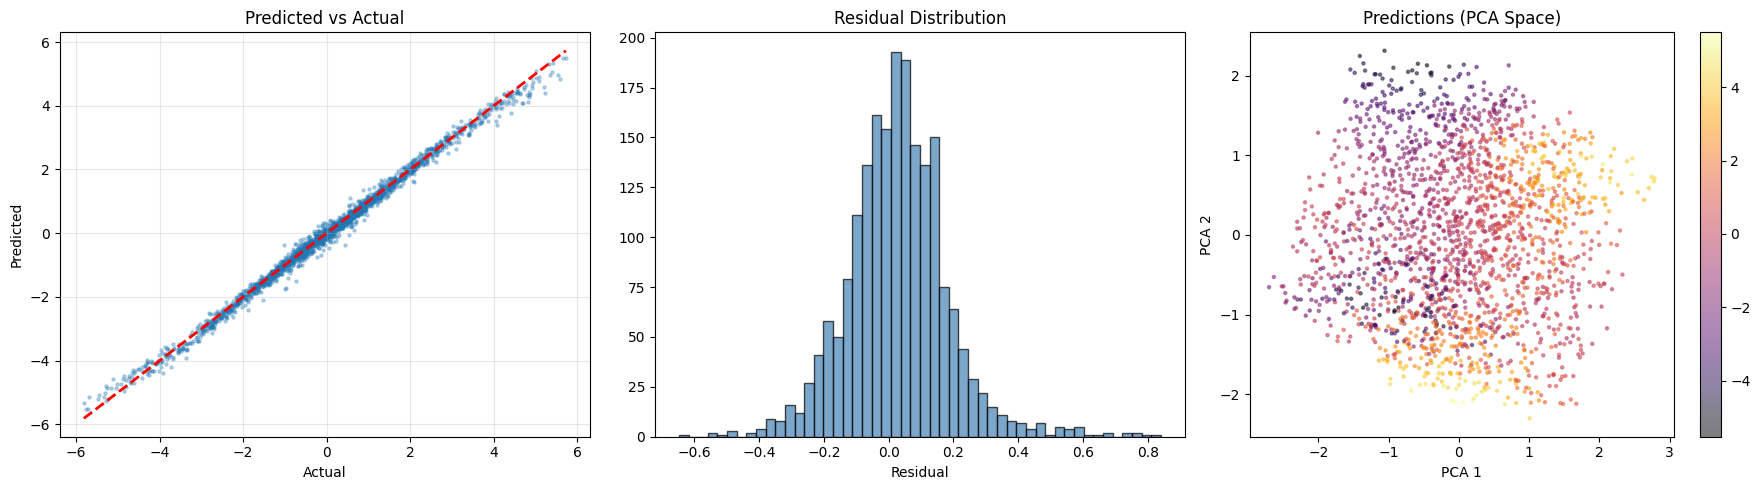

R²: 0.9934 | MAE: 0.1187


In [8]:
model.eval()
X_all = torch.tensor(X_norm, dtype=torch.float32)
with torch.no_grad():
    Y_pred_all = model(X_all).numpy()

Y_pred_denorm = Y_pred_all * Y_std + Y_mean
residuals = Y_np.flatten() - Y_pred_denorm.flatten()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(Y_np.flatten(), Y_pred_denorm.flatten(), alpha=0.3, s=5)
axes[0].plot([Y_np.min(), Y_np.max()], [Y_np.min(), Y_np.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual'); axes[0].set_ylabel('Predicted')
axes[0].set_title('Predicted vs Actual'); axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Residual'); axes[1].set_title('Residual Distribution')

sc = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=Y_pred_denorm.flatten(), cmap='inferno', s=5, alpha=0.5)
axes[2].set_xlabel('PCA 1'); axes[2].set_ylabel('PCA 2')
axes[2].set_title('Predictions (PCA Space)')
plt.colorbar(sc, ax=axes[2])
plt.tight_layout(); plt.show()

r2 = 1 - np.sum(residuals**2) / np.sum((Y_np.flatten() - Y_np.mean())**2)
print(f"R²: {r2:.4f} | MAE: {np.mean(np.abs(residuals)):.4f}")

## Cell 9: Summary

In [9]:
print("="*60)
print("Colab D: PyTorch Lightning DNN — Complete!")
print("="*60)
print("Uses: LightningModule, LightningDataModule, Trainer")
print("Benefits over raw PyTorch:")
print("  - Automatic device management (CPU/GPU)")
print("  - Built-in logging & progress bars")
print("  - Clean separation of concerns")
print("  - Reproducibility via save_hyperparameters()")
print(f"R²: {r2:.4f}")
print("="*60)

Colab D: PyTorch Lightning DNN — Complete!
Uses: LightningModule, LightningDataModule, Trainer
Benefits over raw PyTorch:
  - Automatic device management (CPU/GPU)
  - Built-in logging & progress bars
  - Clean separation of concerns
  - Reproducibility via save_hyperparameters()
R²: 0.9934
